In [1]:
import numpy as np
import pandas as pd

In [2]:
dataset_path = '/kaggle/input/deepfake-faces/metadata.csv'

In [3]:
df = pd.read_csv(dataset_path)

In [4]:
df.head()

,videoname,original_width,original_height,label,original
0,aznyksihgl.mp4,129,129,FAKE,xnojggkrxt.mp4
1,gkwmalrvcj.mp4,129,129,FAKE,hqqmtxvbjj.mp4
2,lxnqzocgaq.mp4,223,217,FAKE,xjzkfqddyk.mp4
3,itsbtrrelv.mp4,186,186,FAKE,kqvepwqxfe.mp4
4,ddvgrczjno.mp4,155,155,FAKE,pluadmqqta.mp4


In [5]:
df.tail()

,videoname,original_width,original_height,label,original
95629,rqcsjlsmiz.mp4,129,129,FAKE,pbsccacgff.mp4
95630,xjmnerypjf.mp4,90,90,FAKE,qrjydgidga.mp4
95631,hnewpzhihy.mp4,75,75,FAKE,vabhbfiifl.mp4
95632,okbarlnmwm.mp4,268,267,FAKE,uqaaspbgtz.mp4
95633,asddammewq.mp4,90,90,FAKE,yfjkgiynbi.mp4


In [6]:
def classify_features(df):
    categorical_features = []
    non_categorical_features = []
    discrete_features = []
    continuous_features = []

    for column in df.columns:
        if df[column].dtype == 'object':
            if df[column].nunique() < 10:
                categorical_features.append(column)
            else:
                non_categorical_features.append(column)
        elif df[column].dtype in ['int64', 'float64']:
            if df[column].nunique() < 10:
                discrete_features.append(column)
            else:
                continuous_features.append(column)

    return categorical_features, non_categorical_features, discrete_features, continuous_features

In [7]:
categorical, non_categorical, discrete, continuous = classify_features(df)

In [8]:
print("Categorical Features:", categorical)
print("Non-Categorical Features:", non_categorical)
print("Discrete Features:", discrete)
print("Continuous Features:", continuous)

Categorical Features: ['label']
Non-Categorical Features: ['videoname', 'original']
Discrete Features: []
Continuous Features: ['original_width', 'original_height']


In [9]:
from sklearn.utils import resample

real_df = df[df['label'] == 'REAL']
fake_df = df[df['label'] == 'FAKE']

num_real = len(real_df)
fake_df_balanced = resample(fake_df, n_samples=num_real, random_state=42)
balanced_df = pd.concat([real_df, fake_df_balanced])
balanced_df = balanced_df.sample(frac=1, random_state=42).reset_index(drop=True)

print(f"Dataset:\n{balanced_df['label'].value_counts()}")

Dataset:
REAL    16293
FAKE    16293
Name: label, dtype: int64


In [10]:
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

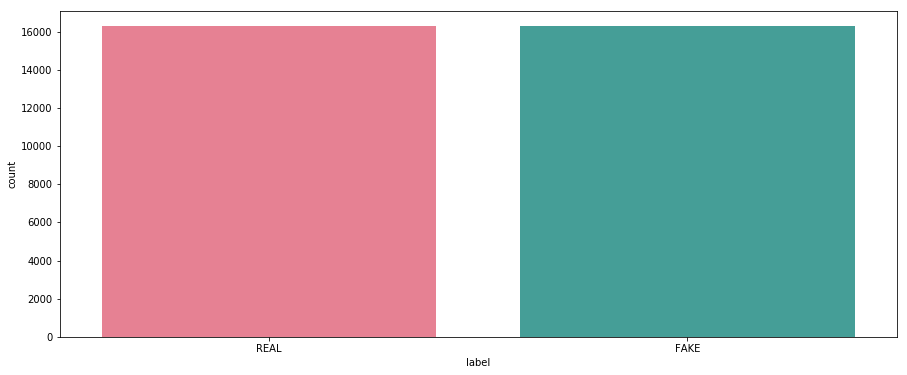

In [11]:
for i in categorical:
    plt.figure(figsize=(15,6))
    sns.countplot(x = balanced_df[i], data =balanced_df, palette = 'husl')
    plt.show()

In [12]:
real_df = balanced_df[balanced_df["label"] == "REAL"]
fake_df = balanced_df[balanced_df["label"] == "FAKE"]
sample_size = 10000

real_df = real_df.sample(sample_size, random_state=42)
fake_df = fake_df.sample(sample_size, random_state=42)

sample_meta = pd.concat([real_df, fake_df])

In [13]:
from sklearn.model_selection import train_test_split

Train_set, Test_set = train_test_split(sample_meta,test_size=0.25,random_state=42,stratify=sample_meta['label'])
Train_set, Val_set  = train_test_split(Train_set,test_size=0.25,random_state=42,stratify=Train_set['label'])

In [14]:
Train_set.shape,Val_set.shape,Test_set.shape

((11250, 5), (3750, 5), (5000, 5))

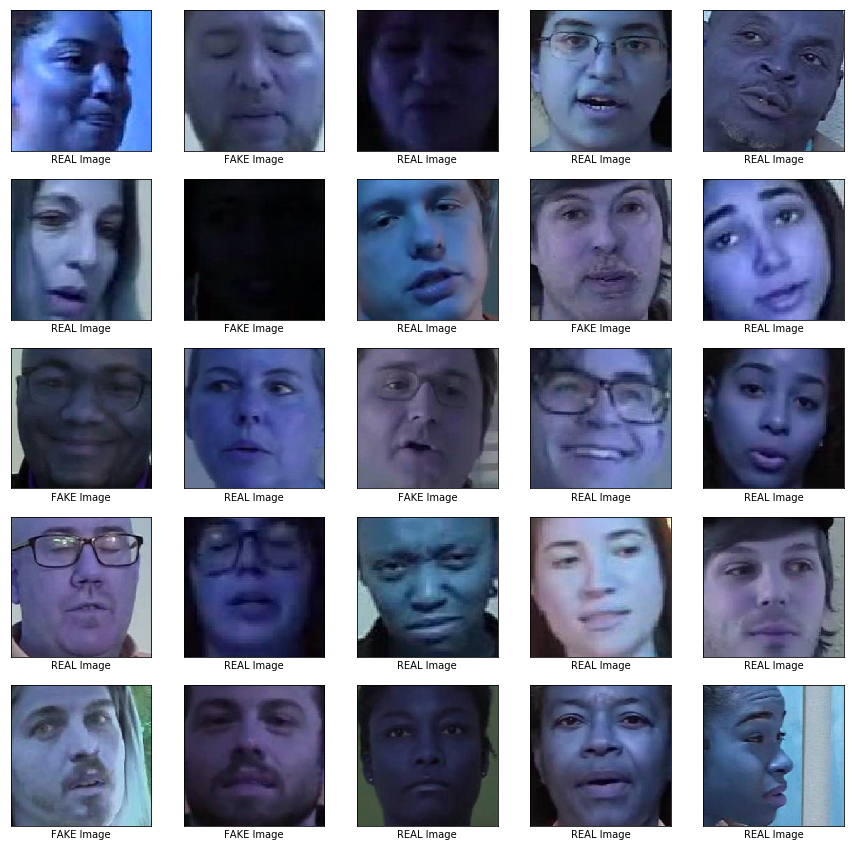

In [15]:
import cv2

plt.figure(figsize=(15,15))
for cur,i in enumerate(Train_set.index[25:50]):
    plt.subplot(5,5,cur+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    
    plt.imshow(cv2.imread('../input/deepfake-faces/faces_224/'+Train_set.loc[i,'videoname'][:-4]+'.jpg'))
    
    if(Train_set.loc[i,'label']=='FAKE'):
        plt.xlabel('FAKE Image')
    else:
        plt.xlabel('REAL Image')
        
plt.show()

In [16]:
def retreive_dataset(set_name):
    images,labels=[],[]
    for (img, imclass) in zip(set_name['videoname'], set_name['label']):
        images.append(cv2.imread('../input/deepfake-faces/faces_224/'+img[:-4]+'.jpg'))
        if(imclass=='FAKE'):
            labels.append(1)
        else:
            labels.append(0)
    
    return np.array(images),np.array(labels)

In [17]:
X_train,y_train=retreive_dataset(Train_set)
X_val,y_val=retreive_dataset(Val_set)
X_test,y_test=retreive_dataset(Test_set)

In [18]:
import tensorflow as tf
from tensorflow.keras import layers, models
from functools import partial

In [19]:
tf.random.set_seed(2)

In [20]:
# model = models.Sequential([
#     layers.Reshape((224, 224 * 3), input_shape=[224, 224, 3]),
#     layers.SimpleRNN(64, activation="relu", return_sequences=False),
#     layers.BatchNormalization(),
#     layers.Dropout(0.5),
#     layers.Dense(units=64, activation="relu", kernel_initializer="he_normal"),
#     layers.BatchNormalization(),
#     layers.Dropout(0.5),
#     layers.Dense(units=1, activation="sigmoid")
# ])

model = models.Sequential([
    layers.Conv2D(16, (3, 3), activation="relu", padding="same", input_shape=(224, 224, 3)),
    layers.BatchNormalization(),
    layers.MaxPooling2D(pool_size=(2, 2)),
    
    layers.Conv2D(64, (3, 3), activation="relu", padding="same"),
    layers.BatchNormalization(),
    layers.MaxPooling2D(pool_size=(2, 2)),
    
    layers.Flatten(),
    
    layers.Dense(16, activation="relu", kernel_initializer="he_normal"),
    layers.BatchNormalization(),
    layers.Dropout(0.5),
    
    layers.Dense(16, activation="relu", kernel_initializer="he_normal"),
    layers.BatchNormalization(),
    layers.Dropout(0.5),
    
    layers.Dense(1, activation="sigmoid")
])

In [21]:
initial_learning_rate = 0.001
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate, decay_steps=100000, decay_rate=0.96, staircase=True
)

In [22]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule),
              loss="mse", metrics=["accuracy"])

In [23]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 224, 224, 16)      448       
_________________________________________________________________
batch_normalization (BatchNo (None, 224, 224, 16)      64        
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 112, 112, 16)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 112, 112, 64)      9280      
_________________________________________________________________
batch_normalization_1 (Batch (None, 112, 112, 64)      256       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 56, 56, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 200704)            0

In [24]:
history = model.fit(
    X_train, y_train,
    epochs=10,  # Adjust as needed
    batch_size=32,  # Adjust as needed
    validation_data=(X_val, y_val),
    verbose=1
)

Train on 11250 samples, validate on 3750 samples
Epoch 1/10
11250/11250 [==============================] - 13s 1ms/sample - loss: 0.3009 - accuracy: 0.5099 - val_loss: 0.2927 - val_accuracy: 0.5165
Epoch 2/10
11250/11250 [==============================] - 9s 838us/sample - loss: 0.2691 - accuracy: 0.5200 - val_loss: 0.2572 - val_accuracy: 0.5389
Epoch 3/10
11250/11250 [==============================] - 10s 848us/sample - loss: 0.2552 - accuracy: 0.5303 - val_loss: 0.2481 - val_accuracy: 0.5253
Epoch 4/10
11250/11250 [==============================] - 9s 842us/sample - loss: 0.2458 - accuracy: 0.5628 - val_loss: 0.2496 - val_accuracy: 0.5219
Epoch 5/10
11250/11250 [==============================] - 9s 841us/sample - loss: 0.2400 - accuracy: 0.5809 - val_loss: 0.2348 - val_accuracy: 0.6064
Epoch 6/10
11250/11250 [==============================] - 9s 841us/sample - loss: 0.2357 - accuracy: 0.6068 - val_loss: 0.2438 - val_accuracy: 0.5573
Epoch 7/10
11250/11250 [===========================

In [25]:
y_pred = model.predict(X_test)

In [26]:
y_test_pred_binary = (y_pred > 0.5).astype(int)

In [27]:
y_test_pred_binary = (y_pred > 0.5).astype(int)
y_train_pred = model.predict(X_train)
y_train_pred_binary = (y_train_pred > 0.5).astype(int)

## Accuracy Metrics

In [28]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix, classification_report, roc_auc_score

train_accuracy = accuracy_score(y_train, y_train_pred_binary)
print(f"Training Accuracy: {train_accuracy * 100:.2f}%")

test_accuracy = accuracy_score(y_test, y_test_pred_binary)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

f1 = f1_score(y_test, y_test_pred_binary)
print(f"F1 Score: {f1:.4f}")

precision = precision_score(y_test, y_test_pred_binary)
print(f"Precison: {precision:.4f}")

recall = recall_score(y_test, y_test_pred_binary)
print(f"Recall: {recall:.4f}")

# Calculate AUC-ROC
auc_roc = roc_auc_score(y_test, y_test_pred_binary)
print(f"AUC-ROC: {auc_roc:.4f}")

Training Accuracy: 67.09%
Test Accuracy: 61.92%
F1 Score: 0.6723
Precison: 0.5900
Recall: 0.7812
AUC-ROC: 0.6192


## Confusion Matrix

In [29]:
conf_matrix = confusion_matrix(y_test, y_test_pred_binary)
print("Confusion Matrix:")
print(conf_matrix)

Confusion Matrix:
[[1143 1357]
 [ 547 1953]]
